In [2]:
import os, glob, math, random
from datetime import datetime
from scipy import stats
from sklearn import metrics
import math
import numpy as np
import pandas as pd
import rasterio
from datetime import datetime
from torch.optim.lr_scheduler import ReduceLROnPlateau
from matplotlib.collections import LineCollection
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from rasterio.plot import show as rio_show
import re
from rasterio.transform import array_bounds
from matplotlib.lines import Line2D
import matplotlib.cm as cm
from tqdm import tqdm
F32_MIN = np.float32(-3.4028235e+38).item()  # ~ -3.40282306e+38 in your files
import pickle
from matplotlib import patheffects as pe
import shapefile
import math, torch, torch.nn as nn, torch.nn.functional as F
from dataclasses import dataclass
import csv
from copy import deepcopy
from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform
from scipy.ndimage import gaussian_filter
import csv
import numpy as np
import torch
import os
import re
import numpy as np
from datetime import datetime
from torch.utils.data import Dataset
import rasterio
import pandas as pd
import torch
import matplotlib.pyplot as plt
import scipy

In [3]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
%load_ext autoreload
%autoreload 2
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import DataLoader,Dataset
import torch
from tqdm import tqdm
import csv
from src.data import  Normalizer, load_classification_pickle, _rowcol_to_xy_vec, _wrap_lon_180, _lonlat_to_rowcol_vec, custom_collate_fn
from src.losses import calculate_metrics, improved_loss_progress
from src.utils import visualize_batch, _add_shape,load_shapefile_segments_pyshp, generate_realistic_gaps_simple
complete, partial, blank = load_classification_pickle(input_file='/work/srs108/pconv2d/file_classification_nop.pkl')
train_files, val_files = train_test_split(complete, test_size=0.2, random_state=42)
tif_dir = '/work/srs108/bigs'
z = np.load("/hpc/home/srs108/normalizer_stats.npz", allow_pickle=True)
normalizer = Normalizer(clip_z=5.0)
normalizer.im_mu = float(z["im_mu"]); normalizer.im_sigma = float(z["im_sigma"])
shp_path="/work/srs108/pconv2d/cus/cb_2018_us_state_500k.shp"
pandora_df = pd.read_csv("/work/srs108/pconv2d/pandora_filtered_data_old.csv", header =0)
pandora_df["datetime"] = pd.to_datetime(pandora_df["datetime"], errors="coerce")

In [4]:
def load_shapefile_segments_pyshp(shp_path, target_crs):
    """
    Returns a list of Nx2 arrays of (x,y) segments in the raster's CRS,
    suitable for matplotlib LineCollection.
    """
    import os
    import numpy as np
    import shapefile  # pyshp
    from pyproj import CRS, Transformer
    from shapely.geometry import shape as shp_shape, LineString, MultiLineString, Polygon, MultiPolygon
    from shapely.ops import transform as shp_transform

    if target_crs is None:
        raise ValueError("target_crs is None (couldn't read raster CRS).")

    # Try to read the .prj next to the .shp; fallback to WGS84
    prj_path = os.path.splitext(shp_path)[0] + ".prj"
    if os.path.exists(prj_path):
        with open(prj_path, "r") as f:
            src_crs = CRS.from_wkt(f.read())
    else:
        src_crs = CRS.from_epsg(4326)  # common default

    transformer = Transformer.from_crs(src_crs, target_crs, always_xy=True)

    rdr = shapefile.Reader(shp_path)
    segments = []

    for sr in rdr.shapeRecords():
        geom = shp_shape(sr.shape.__geo_interface__)

        # Normalize to a list of LineStrings (polygon outlines become lines)
        line_geoms = []
        if isinstance(geom, LineString):
            line_geoms = [geom]
        elif isinstance(geom, MultiLineString):
            line_geoms = list(geom.geoms)
        elif isinstance(geom, Polygon):
            line_geoms = [LineString(geom.exterior.coords)] + [LineString(r.coords) for r in geom.interiors]
        elif isinstance(geom, MultiPolygon):
            for poly in geom.geoms:
                line_geoms.append(LineString(poly.exterior.coords))
                line_geoms += [LineString(r.coords) for r in poly.interiors]
        else:
            continue  # skip points, etc.

        # Reproject & extract segments
        for g in line_geoms:
            g2 = shp_transform(lambda x, y: transformer.transform(x, y), g)
            coords = np.asarray(g2.coords, dtype=np.float32)
            if coords.shape[0] >= 2:
                segments.append(coords)

    return segments


Denormalizing images using custom Normalizer...
t=0: Found 7212 artificial holes
t=1: Found 9020 artificial holes
t=2: Found 6767 artificial holes
t=3: Found 4349 artificial holes
t=4: Found 2214 artificial holes
t=5: Found 949 artificial holes
t=6: Found 2282 artificial holes
t=7: Found 4474 artificial holes
Plot saved to: time_example.png


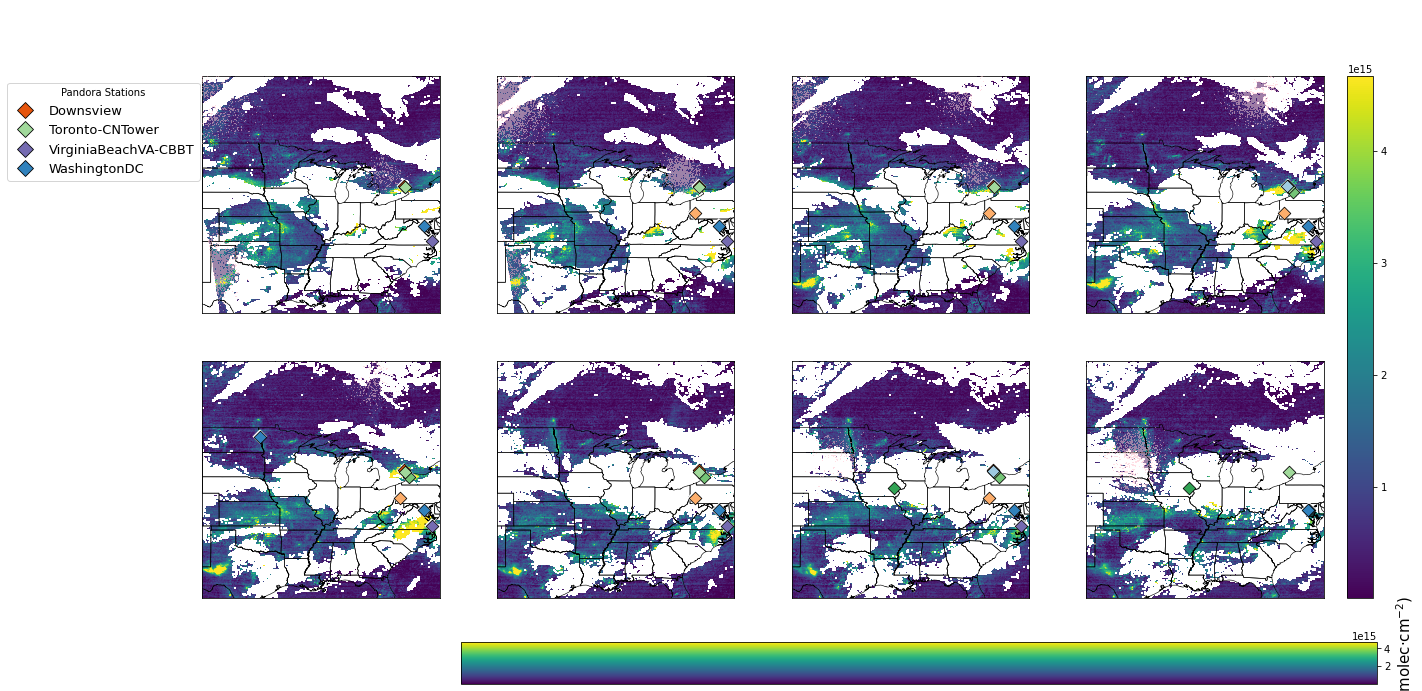

In [9]:
class TempoPandoraInpaintDataset(Dataset):
    F32_MIN = np.float32(-3.4028235e+38).item()

    def __init__(
        self,
        tif_dir,
        normalizer,
        file_list,
        train: bool,
        use_dataset_mask: bool = True,
        treat_zeros_as_missing: bool = False,
        valid_range=None,
        pandora_csv=None,
        time_tolerance="30min",
        # ---- temporal settings ----
        T: int = 8,                 # frames per window
        target_mode: str = "all",   # "all" or "last"
        max_time_gap: str = "2H",   # allowed gap between consecutive frames
        # ---- artificial mask settings (train only) ----
        artif_prob: float = 1.0,           # probability to apply artificial gaps to a sample
        n_blobs_range=(0, 4),              # per-slice number of blobs
        blob_size=(20, 74),                # per-slice blob sigma range (pixels)
        thr_range=(0.55, 0.85),            # threshold range for binary gaps
        artif_mode: str = "3d",         # "off" | "2d" | "3d"
        sigma_t_range=(0.6, 2.0),       # temporal smoothing (frames)
        sigma_xy_range=(18.0, 72.0),    # spatial smoothing (pixels)

    ):
        self.tif_dir = tif_dir
        self.train = bool(train)
        self.normalizer = normalizer
        self.use_dataset_mask = bool(use_dataset_mask)
        self.treat_zeros_as_missing = bool(treat_zeros_as_missing)
        self.valid_range = valid_range

        # temporal configuration
        assert T >= 2 and T % 2 == 0 or T >= 3, "Use a reasonable T (e.g., 8 or 12)."
        self.T = int(T)
        self.pre = (self.T - 1) // 2
        self.post = self.T - self.pre - 1
        self.target_mode = str(target_mode).lower()
        assert self.target_mode in {"all", "last"}
        self.max_time_gap = pd.Timedelta(max_time_gap)

        # artificial masks
        self.artif_prob = float(artif_prob)
        self.n_blobs_range = n_blobs_range
        self.blob_size = blob_size
        self.thr_range = thr_range
        self.artif_mode = str(artif_mode).lower()
        assert self.artif_mode in {"off", "2d", "3d"}
        self.sigma_t_range = sigma_t_range
        self.sigma_xy_range = sigma_xy_range


        # store & index files by timestamp
        self.files = list(file_list)
        self.timestamps = [self._parse_time_from_fname(os.path.basename(p)) for p in self.files]
        order = np.argsort(np.array(self.timestamps, dtype="datetime64[ns]"))
        self.files = [self.files[i] for i in order]
        self.timestamps = [self.timestamps[i] for i in order]

        # precompute valid centers that have a full T window with acceptable time gaps
        self.centers = self._build_centers()

        # -------- Pandora table ----------
        self.pandora_df = None
        self.time_tolerance = pd.Timedelta(time_tolerance)
        if pandora_csv is not None:
            df = pandora_csv.copy() if isinstance(pandora_csv, pd.DataFrame) else pd.read_csv(pandora_csv)
            if "datetime" not in df.columns or "NO2" not in df.columns:
                raise ValueError("Pandora CSV must contain 'datetime' and 'NO2'.")
            df["datetime"] = pd.to_datetime(df["datetime"])
            df = df.sort_values("datetime").reset_index(drop=True)
            self.pandora_df = df

    # ---------- helpers ----------
    def _build_centers(self):
        """Find center indices i such that indices [i-pre, ..., i+post] exist and are temporally close."""
        centers = []
        N = len(self.files)
        for i in range(self.pre, N - self.post):
            ok = True
            # check consecutive gaps inside the window
            t_prev = self.timestamps[i - self.pre]
            for k in range(i - self.pre + 1, i + self.post + 1):
                t_curr = self.timestamps[k]
                if (t_curr - t_prev) > self.max_time_gap:
                    ok = False
                    break
                t_prev = t_curr
            if ok:
                centers.append(i)
        return centers

    @staticmethod
    def _parse_time_from_fname(fname):
        digits = re.sub(r"\D", "", fname)
        fmts = ("%Y%m%d%H%M%S", "%Y%m%d%H%M", "%Y%m%d%H", "%Y%m%d")
        for fmt in fmts:
            try:
                return pd.to_datetime(digits[:len(pd.Timestamp.now().strftime(fmt))], format=fmt)
            except Exception:
                continue
        return pd.NaT

    def _read_band_masked(self, path):
        with rasterio.open(path) as src:
            gdal_known = None
            if self.use_dataset_mask:
                try:
                    m = src.read_masks(1)  # 0=missing, 255=valid
                    if m is not None and m.size:
                        gdal_known = (m > 0)
                except Exception:
                    gdal_known = None

            arr = src.read(1, out_dtype="float64")
            nodatas = []
            if getattr(src, "nodata", None) is not None:
                nodatas.append(src.nodata)
            if getattr(src, "nodatavals", None):
                nodatas += [v for v in src.nodatavals if v is not None]

        known = gdal_known if gdal_known is not None else np.isfinite(arr)
        for nv in nodatas:
            known &= arr != nv
        known &= arr > (self.F32_MIN * 0.9)
        if self.treat_zeros_as_missing:
            known &= arr != 0.0
        if self.valid_range is not None:
            vmin, vmax = self.valid_range
            known &= (arr >= vmin) & (arr <= vmax)

        arr_valid = np.where(known, arr, np.nan)
        return arr_valid, known.astype(np.uint8)

    def _make_spatiotemporal_blob_mask(self, T, H, W, keep_mask_3d, rng):
        """
        Simpler approach with more evenly distributed holes.
        """
        # Start with all kept
        keep = np.ones((T, H, W), dtype=np.float32)

        # Create multiple smaller blobs throughout
        n_blobs = rng.integers(self.n_blobs_range[0] * 3, self.n_blobs_range[1] * 3 + 1)
        if n_blobs <= 0:
            return keep

        # Create blob centers across the volume
        for _ in range(n_blobs):
            # Position blob center more evenly throughout volume
            t_center = rng.integers(0, T)
            y_center = rng.integers(0, H)
            x_center = rng.integers(0, W)

            # Size of blob (smaller than original to distribute more evenly)
            sigma_t = float(rng.uniform(self.sigma_t_range[0] * 0.5, self.sigma_t_range[1] * 0.5))
            sigma_xy = float(rng.uniform(self.sigma_xy_range[0] * 0.7, self.sigma_xy_range[1] * 0.7))

            # Create single blob with Gaussian falloff
            t_grid, y_grid, x_grid = np.meshgrid(
                np.arange(T), np.arange(H), np.arange(W), indexing='ij'
            )

            # Distance from center
            dist = np.sqrt(
                ((t_grid - t_center) / max(1, sigma_t))**2 + 
                ((y_grid - y_center) / max(1, sigma_xy))**2 + 
                ((x_grid - x_center) / max(1, sigma_xy))**2
            )

            # Probability of hole based on distance
            prob_hole = np.exp(-dist**2 / 2)

            # Randomly decide which points become holes based on probability
            random_field = rng.uniform(0, 1, (T, H, W))
            new_holes = (random_field < prob_hole * 0.8).astype(np.float32)

            # Remove holes from keep mask (but respect original valid data)
            keep *= (1.0 - new_holes * keep_mask_3d)

        return keep

    def _make_spatial_slice_mask_stack(self, m_known, rng):
        """Your current 2D blob logic applied independently per slice."""
        T, H, W = m_known.shape
        m_keep = []
        for t in range(T):
            m_keep.append(self._make_gaussian_blob_mask(H, W, m_known[t], rng))
        return np.stack(m_keep, axis=0).astype(np.float32)


    # ---------- Pandora for a single path ----------
    def _pandora_for_path(self, path):
        with rasterio.open(path) as src:
            H, W = src.height, src.width
            tr, crs = src.transform, src.crs

        pandora_mask = np.zeros((H, W), dtype=np.float32)
        pandora_val_map = np.zeros((H, W), dtype=np.float32)
        station_names = []

        ts = self._parse_time_from_fname(os.path.basename(path))
        if (self.pandora_df is not None) and (ts is not pd.NaT):
            dfw = self.pandora_df[
                (self.pandora_df["datetime"] >= ts - self.time_tolerance) &
                (self.pandora_df["datetime"] <= ts + self.time_tolerance)
            ].copy()
            if not dfw.empty:
                if "station" in dfw.columns:
                    dfw["abs_dt"] = (dfw["datetime"] - ts).abs()
                    dfw = dfw.sort_values(["station", "abs_dt"]).groupby("station", as_index=False).first()

                if ("row" in dfw.columns) and ("col" in dfw.columns):
                    rows = dfw["row"].astype(int).to_numpy()
                    cols = dfw["col"].astype(int).to_numpy()
                else:
                    if {"lat", "lon"}.issubset(set(dfw.columns)):
                        xs = dfw["lon"].to_numpy(); ys = dfw["lat"].to_numpy()
                        rc = [~tr * (x, y) for x, y in zip(xs, ys)]
                        cols = np.array([int(round(c)) for c, r in rc])
                        rows = np.array([int(round(r)) for c, r in rc])
                    else:
                        rows = np.array([], dtype=int); cols = np.array([], dtype=int)

                ok = (rows >= 0) & (rows < H) & (cols >= 0) & (cols < W)
                rows, cols = rows[ok], cols[ok]
                vals = dfw.loc[ok, "NO2"].astype(float).to_numpy()

                dfw_ok = dfw.loc[ok].reset_index(drop=True)
                station_names_raw = dfw_ok["station"].astype(str).to_numpy() if "station" in dfw_ok.columns else []

                if hasattr(self.normalizer, "normalize_pandora_array"):
                    vals_n = self.normalizer.normalize_pandora_array(vals.astype(np.float64)).astype(np.float32)
                elif hasattr(self.normalizer, "normalize_pandora"):
                    vals_n = np.array([self.normalizer.normalize_pandora(v) for v in vals], dtype=np.float32)
                else:
                    vals_n = vals.astype(np.float32)

                for i, (r, c, v_n) in enumerate(zip(rows, cols, vals_n)):
                    pandora_mask[r, c] = 1.0
                    pandora_val_map[r, c] = v_n
                    station_names.append(station_names_raw[i] if i < len(station_names_raw) else f"Unknown_{i}")

        return pandora_mask, pandora_val_map, station_names

    def sample_vis(self, idx=None, max_cols=4, shp_path=shp_path, plot_pandora=True, seed=42, 
               denormalize=True, save_path='time_example.png'):
        import math, re
        import numpy as np
        import pandas as pd
        import matplotlib.pyplot as plt
        from datetime import datetime
        import rasterio
        from rasterio.transform import array_bounds
        import os

        rng = np.random.default_rng(seed)
        if idx is None:
            idx = 42#np.random.randint(len(self))

        sample = self[idx]

        # -------- helpers --------
        def _add_shape_and_pandora(ax, tr, crs, ts, segments, plot_pandora=True):
            """
            Draw shapefile lines and Pandora stations (categorical colors by station).
            Returns (has_pandora, legend_handles, shown_labels) so you can place a legend.
            """
            # ---- shapefile ----
            if segments:
                ax.add_collection(LineCollection(segments, colors='k', linewidths=0.6, zorder=3))

            has_pandora = False
            legend_handles = []
            shown_labels = []

            # ---- Pandora (categorical by station) ----
            if (plot_pandora and
                getattr(self, "pandora_df", None) is not None and
                ts is not pd.NaT and
                not self.pandora_df.empty and
                "station" in self.pandora_df.columns):

                # time-window filter
                dfw = self.pandora_df[
                    (self.pandora_df["datetime"] >= ts - self.time_tolerance) &
                    (self.pandora_df["datetime"] <= ts + self.time_tolerance)
                ].copy()
                if dfw.empty:
                    return has_pandora, legend_handles, shown_labels

                # nearest per-station in time
                dfw["abs_dt"] = (dfw["datetime"] - ts).abs()
                dfw = dfw.sort_values(["station", "abs_dt"]).groupby("station", as_index=False).first()

                # stable color per station (based on the full catalog)
                stations_all = (self.pandora_df["station"]
                                .dropna().astype(str).unique())
                palette = cm.tab20c(np.linspace(0, 1, max(1, len(stations_all))))
                station2color = dict(zip(stations_all, palette))

                # coordinates → row/col
                if {"row", "col"}.issubset(dfw.columns):
                    rows = dfw["row"].astype(int).to_numpy()
                    cols = dfw["col"].astype(int).to_numpy()
                elif {"lat", "lon"}.issubset(dfw.columns):
                    # lon/lat → col/row using the raster's transform
                    xs = _wrap_lon_180(pd.to_numeric(dfw["lon"], errors="coerce").to_numpy())
                    ys = pd.to_numeric(dfw["lat"], errors="coerce").to_numpy()
                    ok_ll = np.isfinite(xs) & np.isfinite(ys) & (ys >= -90) & (ys <= 90)
                    dfw = dfw.loc[ok_ll].copy()
                    cols_rows = [~tr * (x, y) for x, y in zip(xs[ok_ll], ys[ok_ll])]
                    cols = np.array([int(round(c)) for c, r in cols_rows])
                    rows = np.array([int(round(r)) for c, r in cols_rows])
                else:
                    return has_pandora, legend_handles, shown_labels

                # keep only inside image
                H, W = int(ax.images[0].get_array().shape[0]), int(ax.images[0].get_array().shape[1])
                ok_in = (rows >= 0) & (rows < H) & (cols >= 0) & (cols < W)
                if ok_in.sum() == 0:
                    return has_pandora, legend_handles, shown_labels

                rows, cols = rows[ok_in], cols[ok_in]
                labels = dfw.loc[ok_in, "station"].astype(str).to_numpy()

                # row/col → x/y for plotting in map coords
                xs, ys = _rowcol_to_xy_vec(rows, cols, tr)

                # plot (white halo + colored diamond per station)
                has_pandora = True
                ax.scatter(xs, ys, s=110, marker='D', facecolor='white',
                           edgecolor='none', zorder=7)
                for x, y, lab in zip(xs, ys, labels):
                    c = station2color.get(lab, (0.2, 0.2, 0.2, 1.0))
                    ax.scatter(x, y, s=80, marker='D', facecolor=c,
                               edgecolor='k', linewidth=0.8, zorder=8)

                # legend handles (one per unique label actually shown)
                for lab in np.unique(labels):
                    c = station2color.get(lab, (0.2, 0.2, 0.2, 1.0))
                    proxy = Line2D([0], [0], marker='D', color='none',
                                   markerfacecolor=c, markeredgecolor='k',
                                   markeredgewidth=0.8, markersize=9, label=lab)
                    legend_handles.append(proxy)
                shown_labels = list(np.unique(labels))

            return has_pandora, legend_handles, shown_labels

        def get_any(keys, default=None, required=False):
            for k in keys:
                if k in sample and sample[k] is not None:
                    return sample[k]
            if required:
                raise KeyError(f"None of keys {keys} found in sample. Available: {list(sample.keys())}")
            return default

        def to_THW(x):
            """Accepts 2D/3D/4D, returns [T,H,W]."""
            if x is None:
                return None
            a = x.detach().cpu().numpy() if hasattr(x, "detach") else np.asarray(x)
            if a.ndim == 2:                 # [H,W]
                return a[None, ...]         # [1,H,W]
            if a.ndim == 3:                 # [T,H,W] or [C,H,W]
                return a                    # assume T==first dim
            if a.ndim == 4:                 # [1,T,H,W] or [T,1,H,W]
                if a.shape[0] == 1:         # [1,T,H,W] -> [T,H,W]
                    return a[0]
                if a.shape[1] == 1:         # [T,1,H,W] -> [T,H,W]
                    return a[:,0]
            raise ValueError(f"Expected 2D/3D/4D array, got shape {a.shape}")

        # -------- fetch arrays (robust key mapping) --------
        img_in   = to_THW(get_any(["masked_img", "img_in"], required=True))
        target   = to_THW(get_any(["target"], required=True))
        mask_real= to_THW(get_any(["mask_real","mask_known","mask_observed","mask_dataset","known_mask"], required=True)) # 1=valid
        mask_aug = to_THW(get_any(["mask_aug","mask_gauss","fake_mask","mask_sp","mask_art"], required=False))           # 1=kept
        mask_eff = to_THW(get_any(["mask_in","mask_effective","known_and_fake_mask"], required=False))                  # effective

        # DENORMALIZE THE IMAGES using the custom Normalizer
        if denormalize:
            if hasattr(self, 'normalizer') and self.normalizer is not None:
                print("Denormalizing images using custom Normalizer...")
                # Denormalize each time step
                T, H, W = img_in.shape
                img_in_denorm = np.zeros_like(img_in, dtype=np.float64)
                target_denorm = np.zeros_like(target, dtype=np.float64)

                for t in range(T):
                    img_in_denorm[t] = self.normalizer.denormalize_image(img_in[t])
                    target_denorm[t] = self.normalizer.denormalize_image(target[t])

                img_in = img_in_denorm
                target = target_denorm
            else:
                print("Warning: No normalizer found in dataset, using original normalized values")

        # paths/timestamps per time step (optional)
        paths_t  = get_any(["path_t","path","path_list"], default=None)
        if paths_t is None:
            p = get_any(["path"], required=True)
            paths_t = [p] * img_in.shape[0]
        ts_list  = get_any(["ts_t","timestamps","ts_list"], default=None)

        T, H, W = target.shape

        # -------- color scale from target (now denormalized) --------
        finite_all = np.isfinite(target)
        if finite_all.any():
            if denormalize:
                # For denormalized data, use appropriate percentiles
                vmin, vmax = np.percentile(target[finite_all], [1, 99])
            else:
                # For normalized data, use tighter percentiles
                vmin, vmax = np.percentile(target[finite_all], [2, 98])
        else:
            vmin, vmax = 0.0, 1.0

        cmap_v = plt.cm.viridis.copy(); cmap_v.set_bad("white")

        # shapefile segments & reference geo from first path
        segments = []
        ref_tr = ref_crs = None
        if shp_path is not None and len(paths_t) > 0:
            with rasterio.open(paths_t[0]) as src0:
                ref_tr, ref_crs = src0.transform, src0.crs
            try:
                segments = load_shapefile_segments_pyshp(shp_path, ref_crs)
            except Exception:
                segments = []

        # layout
        ncols = min(max_cols, T)
        nrows = math.ceil(T / ncols)
        fig, axes = plt.subplots(nrows, ncols, figsize=(5.3*ncols, 4.8*nrows), squeeze=False)
        

        legend_handles_all = None
        used_any_stations = False

        for t in range(T):
            r, c = t // ncols, t % ncols
            ax = axes[r, c]

            path_t = paths_t[t] if t < len(paths_t) else paths_t[0]
            with rasterio.open(path_t) as src:
                tr, crs = src.transform, src.crs
                xmin, ymin, xmax, ymax = array_bounds(src.height, src.width, tr)

            # timestamp label
            if ts_list is not None and t < len(ts_list) and isinstance(ts_list[t], pd.Timestamp):
                ts = ts_list[t]
                dt_label = ts.strftime("%Y-%m-%d %H:%M:%S")
                title_label = ts.strftime("%Y-%m-%d")
            else:
                base = re.sub(r"\D", "", str(path_t))[:14]
                try:
                    ts = pd.to_datetime(base, format="%Y%m%d%H%M%S", errors="coerce")
                    dt_label = ts.strftime("%Y-%m-%d %H:%M:%S") if pd.notna(ts) else str(path_t)
                    
                except Exception:
                    ts = pd.NaT
                    dt_label = str(path_t)

            # effective mask to whiten holes
            if mask_eff is not None:
                eff = mask_eff[t].astype(bool)
            else:
                real_valid = mask_real[t].astype(bool)
                aug_keep   = mask_aug[t].astype(bool) if mask_aug is not None else np.ones((H,W), bool)
                eff = real_valid & aug_keep

            # base image (now potentially denormalized)
            ax_img = ax.imshow(np.ma.array(img_in[t], mask=~eff),
                               cmap=cmap_v, vmin=vmin, vmax=vmax,
                               extent=[xmin, xmax, ymin, ymax], origin='upper', zorder=1)

            # Create a base image where real holes are white and the rest shows the actual data
            img_with_holes = img_in[t].copy()
            img_with_holes[~np.isfinite(img_with_holes)] = np.nan  # Ensure non-finite values are NaN

            # Create masked array where real holes are masked (will appear white)
            img_masked = np.ma.array(img_with_holes, mask=~(mask_real[t].astype(bool)))

            # Display the base image with real holes as white
            ax_img = ax.imshow(img_masked, cmap=cmap_v, vmin=vmin, vmax=vmax,
                               extent=[xmin, xmax, ymin, ymax], origin='upper', zorder=1)

            # Plot artificial holes in blue (but only where original data is valid)
            if mask_aug is not None:
                art_holes = (mask_aug[t] == 0) & (mask_real[t] == 1)  # Only where real data exists
                if np.any(art_holes):
                    # Create blue overlay for artificial holes
                    from matplotlib.colors import ListedColormap
                    blue_cmap = ListedColormap(['none', 'pink'])
                    ax.imshow(art_holes, cmap=blue_cmap, alpha=0.5,
                              extent=[xmin, xmax, ymin, ymax], origin='upper', zorder=4)
                    print(f"t={t}: Found {np.sum(art_holes)} artificial holes")

            # Add legend for masks (only on first subplot)
            if t == 0:
                legend_elements = []
                if np.any(~(mask_real[t].astype(bool))):
                    legend_elements.append(plt.Rectangle((0,0),1,1, facecolor='white', edgecolor='gray', 
                                                        label='Real holes (missing data)'))
                if mask_aug is not None and np.any(art_holes):
                    legend_elements.append(plt.Rectangle((0,0),1,1, facecolor='blue', alpha=0.5, 
                                                        label='Artificial holes'))

                if legend_elements:
                    ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

            # shapefile + Pandora
            has_pandora, legend_handles, shown_labels = _add_shape_and_pandora(ax, tr, crs, ts, segments, plot_pandora=plot_pandora)
            if has_pandora and not used_any_stations and legend_handles:
                legend_handles_all = legend_handles
                used_any_stations = True

            # Add denormalization status to title
            ax.set_title(f"t={t}  {dt_label}", fontsize=13, color='white')
            ax.set_aspect('equal')
            ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
            ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

            # stash first image handle for colorbar
            if t == 0:
                first_im = ax_img

        # hide empties
        for k in range(T, nrows*ncols):
            r, c = k // ncols, k % ncols
            axes[r, c].axis("off")

        # single colorbar with appropriate label
        if 'first_im' in locals():
            cbar = fig.colorbar(first_im, ax=axes, fraction=0.025, pad=0.02)
            
            cbar_ax = fig.add_axes([0.25, 0.0008, 0.6, 0.03]) # [left, bottom, width, height] in figure coords
            cbar_ax.tick_params(axis='x', colors ='black' , labelcolor = 'black')
            fig.colorbar(first_im, cax=cbar_ax, orientation="vertical").set_label("NO₂ (molec·cm$^{-2}$)", fontsize=15, color ='black')

            
            if denormalize:
                cbar.set_label("NO₂ (molec$\cdot$cm$^{-2}$)", rotation=90, fontsize=13, color = 'white')
            else:
                cbar.set_label("NO₂ (normalized)", rotation=90, fontsize=13, color = 'white')

        # station legend on first axis if available
        if used_any_stations and legend_handles_all:
            axes[0,0].legend(handles=legend_handles_all,
                             bbox_to_anchor=(-0.85, 1.0), loc="upper left",
                             frameon=True, fontsize=13, markerscale=1.2,
                             title="Pandora Stations")

        fig.suptitle(f"NO₂ Time Series {title_label}", fontsize=22, fontweight='bold', color= 'white', y=0.98)
        if save_path:
            # Create directory if it doesn't exist
            save_dir = os.path.dirname(save_path)
            if save_dir and not os.path.exists(save_dir):
                os.makedirs(save_dir)

            plt.savefig(save_path, dpi=150, bbox_inches="tight")
            print(f"Plot saved to: {save_path}")
    
    plt.show()
    def __len__(self):
        return len(self.centers)

    def __getitem__(self, idx):
        center_idx = self.centers[idx]
        idxs = list(range(center_idx - self.pre, center_idx + self.post + 1))
        paths = [self.files[i] for i in idxs]
        ts_list = [self.timestamps[i] for i in idxs]

        # read stack
        imgs = []
        m_known = []
        H = W = None
        for p in paths:
            arr_valid, known_mask = self._read_band_masked(p)
            arr = np.nan_to_num(arr_valid, nan=0.0).astype(np.float64)
            if H is None:
                H, W = arr.shape
            imgs.append(self.normalizer.normalize_image(arr))
            m_known.append(known_mask.astype(np.float32))
        imgs = np.stack(imgs, axis=0)        # [T,H,W]
        m_known = np.stack(m_known, axis=0)  # [T,H,W]

        # artificial masks (train only)
        rng = np.random.default_rng()
        if self.train and (rng.random() < self.artif_prob) and (self.artif_mode != "off"):
            if self.artif_mode == "3d":
                # spatiotemporally coherent holes across the window
                m_fake = self._make_spatiotemporal_blob_mask(self.T, H, W, m_known, rng)  # [T,H,W], 1=keep
            else:  # "2d"
                m_fake = self._make_spatial_slice_mask_stack(m_known, rng)                # [T,H,W]
        else:
            m_fake = np.ones_like(m_known, dtype=np.float32)

        # effective training mask: 1=keep, 0=hole
        m_eff = (m_known * m_fake).astype(np.float32)
        m_holes = (m_known * (1.0 - m_fake)).astype(np.float32)  # 1 where we purposely removed valid pixels

        # input with holes
        x_masked = (imgs * m_eff).astype(np.float32)  # [T,H,W]

        # target
        if self.target_mode == "all":
            target_np = imgs.astype(np.float32)              # [T,H,W]
        else:  # "last"
            target_np = imgs[None, -1, :, :].astype(np.float32)  # [1,H,W]

        # add channel dim: dataset -> [C, T, H, W] for inputs/masks
        x       = torch.from_numpy(x_masked).unsqueeze(0).float()  # [1,T,H,W]
        m_in    = torch.from_numpy(m_eff).unsqueeze(0).float()      # [1,T,H,W]
        m_known_t = torch.from_numpy(m_known).unsqueeze(0).float()  # [1,T,H,W]
        m_fake_t  = torch.from_numpy(m_fake).unsqueeze(0).float()   # [1,T,H,W]
        m_holes_t = torch.from_numpy(m_holes).unsqueeze(0).float()  # [1,T,H,W]

#         print(
#                 f"known%={m_known.mean():.3f}  "
#                 f"fake_keep%={m_fake.mean():.3f}  "
#                 f"eff_keep%={m_eff.mean():.3f}  "
#                 f"art_holes%={m_holes.mean():.3f}"
#             )
        if self.target_mode == "all":
            y = torch.from_numpy(target_np).unsqueeze(0).float()    # [1,T,H,W]
        else:
            y = torch.from_numpy(target_np).unsqueeze(0).float()    # [1,1,H,W]

        # Pandora (center slice only)
        center_path = paths[self.pre]
        p_mask, p_val_map, station_names = self._pandora_for_path(center_path)

        sample = {
            "masked_img": x,                 # [1,T,H,W]
            "known_and_fake_mask": m_in,             # [1,T,H,W]
            "known_mask": m_known_t,     # [1,T,H,W]
            "fake_mask": m_fake_t,       # [1,T,H,W]
            "target": y,                 # [1,T,H,W] or [1,1,H,W]
            "path": paths,
            "center_path": center_path,
            "timestamps": ts_list,
            "p_mask": torch.from_numpy(p_mask),
            "p_val_mask": torch.from_numpy(p_val_map),
            "station_names": station_names,
            "mask_holes": m_holes_t,   # where we deliberately removed valid pixels (inside-hole loss focus)

        }
        return sample

train_ds = TempoPandoraInpaintDataset(tif_dir=tif_dir,normalizer=normalizer, train=True, file_list=train_files, pandora_csv=pandora_df)
train_ds.sample_vis(denormalize = True)


In [5]:
train_loader = DataLoader(
    train_ds, 
    batch_size=4, 
    shuffle=True, collate_fn=custom_collate_fn)


In [35]:
# ===========================
# 3D PARTIAL-CONV U-NET SKETCH
# ===========================
# This is a compact, production-friendly reference with heavy comments.
# It follows the blueprint: learn directly from incomplete data, propagate
# the mask through the network, and regularize to avoid ringing at hole edges.

import math
from typing import Tuple, List, Optional, Dict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler

class PartialConv3d(nn.Module):
    """
    A 3D partial convolution layer:
    - Multiplies the input by a binary mask (1=valid, 0=missing)
    - Convolves the masked input
    - Normalizes the output by valid-count ratio so mean/scale stay consistent
    - Updates the mask by convolving the mask with a ones-kernel and checking >0
    """
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: Tuple[int,int,int]=(3,3,3),
        stride: Tuple[int,int,int]=(1,1,1),
        padding: Tuple[int,int,int]=(1,1,1),
        dilation: Tuple[int,int,int]=(1,1,1),
        bias: bool=True,
    ):
        super().__init__()
        self.conv = nn.Conv3d(
            in_channels, out_channels,
            kernel_size=kernel_size, stride=stride,
            padding=padding, dilation=dilation, bias=bias
        )
        # A ones kernel to count valid entries in each window.
        self.register_buffer(
            "mask_kernel",
            torch.ones(1, 1, *self.conv.kernel_size, dtype=torch.float32)
        )
        self.stride    = self.conv.stride
        self.padding   = self.conv.padding
        self.dilation  = self.conv.dilation
        self.kernel_sz = math.prod(self.conv.kernel_size)
        self.eps = 1e-8

    def forward(self, x: torch.Tensor, mask: torch.Tensor):
        """
        x:    [B, C_in, D, H, W]
        mask: [B, 1,    D, H, W]  (single-channel binary mask: 1=valid/kept)
        returns: y, new_mask
          y:         [B, C_out, D', H', W']
          new_mask:  [B, 1,     D', H', W']  (where any valid was seen in the window)
        """
        # 1) Mask the input so invalid voxels don't contribute.
        x_masked = x * mask

        # 2) Convolve masked input.
        y = self.conv(x_masked)

        # 3) Count how many valid values entered each convolution window.
        #    We convolve the mask with a ones-kernel using the SAME hyperparams.
        with torch.no_grad():
            valid_count = F.conv3d(
                mask,
                self.mask_kernel.to(mask.dtype),
                bias=None,
                stride=self.stride,
                padding=self.padding,
                dilation=self.dilation
            )

        # 4) Normalize: when only k out of K values are valid, scale by K/k
        #    so that the expected activation doesn't sink at hole borders.
        #    Where no valid values (k=0), we set y=0.
        mask_nonzero = (valid_count > 0).to(y.dtype)
        safe_count = torch.where(valid_count > 0, valid_count, torch.ones_like(valid_count))
        ratio = self.kernel_sz / (safe_count + self.eps)

        y = y * ratio * mask_nonzero


        # 5) New mask: a location is "known" in the next feature map if we saw any
        #    valid input in its receptive field.
        new_mask = mask_nonzero

        return y, new_mask


# ---------------------------------
# Building blocks: PConv + Norm + NL
# ---------------------------------
class PConvBNAct3D(nn.Module):
    """
    PartialConv3d + (optional) normalization + activation.
    We use InstanceNorm (works well for remote-sensing blocks), but GroupNorm
    is also a solid choice for small batches.
    """
    def __init__(self, in_ch, out_ch, k=3, s=1, p=1, norm="in", act="lrelu"):
        super().__init__()
        self.pconv = PartialConv3d(in_ch, out_ch, kernel_size=(k,k,k), stride=(s,s,s), padding=(p,p,p))
        if norm == "in":
            self.norm = nn.InstanceNorm3d(out_ch, affine=True, eps=1e-5)
        elif norm == "gn":
            self.norm = nn.GroupNorm(num_groups=min(8, out_ch), num_channels=out_ch, affine=True)
        else:
            self.norm = nn.Identity()
        if act == "lrelu":
            self.act = nn.LeakyReLU(0.2, inplace=True)
        elif act == "relu":
            self.act = nn.ReLU(inplace=True)
        else:
            self.act = nn.Identity()

    def forward(self, x, m):
        x, m = self.pconv(x, m)   # partial conv + mask update
        x = self.norm(x)          # stabilize feature stats
        x = self.act(x)           # nonlinearity
        return x, m


# ------------------------
# 3D U-Net with PConvs
# ------------------------
class PConvUNet3D(nn.Module):
    """
    U-Net encoder-decoder built entirely with PartialConv3d.
    Down path uses stride-2 PConvs to downsample x and the mask together.
    Up path upsamples feature & mask, concatenates with skip, then PConv fuses.
    """
    def __init__(
        self,
        in_ch: int = 1,
        out_ch: int = 1,
        features: List[int] = (32, 64, 128, 256),  # deeper -> bigger receptive field
        norm: str = "in"
    ):
        super().__init__()
        chs = [in_ch] + list(features)

        # Encoder (Down)
        downs = []
        for i in range(len(features)):
            # First block: stride 1 (refine), second block: stride 2 (downsample)
            downs.append(nn.ModuleList([
                PConvBNAct3D(chs[i], chs[i+1], k=3, s=1, p=1, norm=norm),
                PConvBNAct3D(chs[i+1], chs[i+1], k=3, s=2, p=1, norm=norm),  # stride-2 downsample
            ]))
        self.downs = nn.ModuleList(downs)

        # Bottleneck
        self.bottleneck1 = PConvBNAct3D(features[-1], features[-1]*2, k=3, s=1, p=1, norm=norm)
        self.bottleneck2 = PConvBNAct3D(features[-1]*2, features[-1], k=3, s=1, p=1, norm=norm)

        # Decoder (Up): mirror depth
        ups = []
        for i in reversed(range(len(features))):
            in_dec = features[i] + (features[i+1] if i < len(features)-1 else features[i])  # concat skip+up
            # After upsample and concat, fuse with PConv blocks
            ups.append(nn.ModuleList([
                PConvBNAct3D(in_dec, features[i], k=3, s=1, p=1, norm=norm),
                PConvBNAct3D(features[i], features[i], k=3, s=1, p=1, norm=norm),
            ]))
        self.ups = nn.ModuleList(ups)

        # Final head: 1x1x1 PConv to desired output channels
        self.head = PartialConv3d(features[0], out_ch, kernel_size=(1,1,1), stride=(1,1,1), padding=(0,0,0))

    @staticmethod
    def _upsample_feat_mask(x, m, size: Tuple[int,int,int]):
        # Trilinear for features (smooth), nearest for masks (binary)
        x_up = F.interpolate(x, size=size, mode="trilinear", align_corners=False)
        m_up = F.interpolate(m, size=size, mode="nearest")
        # Ensure binary in {0,1}
        m_up = (m_up > 0.5).float()
        return x_up, m_up
    def forward(self, x: torch.Tensor, m: torch.Tensor):
        """
        x: [B, 1, T, H, W], m: [B, 1, T, H, W]
        returns: pred [B, 1, T, H, W], m_out [B, 1, T, H, W]
        """
        # --------- Encoder ---------
        skips: List[Tuple[torch.Tensor, torch.Tensor]] = []
        h, mh = x, m
        for block1, block2 in self.downs:
            h, mh = block1(h, mh)   # stride-1 refine
            h, mh = block2(h, mh)   # stride-2 downsample (shrinks D/H/W)
            skips.append((h, mh))   # store after downsample for symmetric sizes

        # --------- Bottleneck ---------
        h, mh = self.bottleneck1(h, mh)
        h, mh = self.bottleneck2(h, mh)

        # --------- Decoder ---------
        for (block1, block2), (skip_h, skip_m) in zip(self.ups, reversed(skips)):
            # Upsample to skip's spatial/temporal size
            h, mh = self._upsample_feat_mask(h, mh, size=skip_h.shape[2:])
            # Concatenate features; merge masks (logical OR gives more "known")
            h = torch.cat([h, skip_h], dim=1)
            mh = torch.maximum(mh, skip_m)

            h, mh = block1(h, mh)
            h, mh = block2(h, mh)

        # --------- Head ---------
        y, m_out = self.head(h, mh)  # final PConv so mask propagates

        # --------- Force resize to match input size ---------
        # If rounding during down/upsampling caused mismatch, fix it here.
        if y.shape[2:] != x.shape[2:]:
            y = F.interpolate(y, size=x.shape[2:], mode="trilinear", align_corners=False)
            m_out = F.interpolate(m_out, size=x.shape[2:], mode="nearest")

        return y, m_out



# -------------------------
# Masked Losses & Metrics
# -------------------------
def mae_masked(pred, target, mask, eps=1e-8):
    while mask.dim() < pred.dim():
        mask = mask.unsqueeze(1)
    mask = mask.to(pred.dtype)

    denom = mask.sum()
    if denom < 1:
        return torch.tensor(0.0, device=pred.device, dtype=pred.dtype)

    diff = (pred - target).abs() * mask
    return diff.sum() / denom



def tv3d_masked(x: torch.Tensor, mask: torch.Tensor, eps: float=1e-8):
    """
    Total variation over a masked region: encourages smoothness within holes,
    reducing ringing near boundaries.
    """
    # Ensure mask matches dimensionality (broadcast channel)
    while mask.dim() < x.dim():
        mask = mask.unsqueeze(1)
    mask = mask.to(x.dtype)

    tv = 0.0
    # Differences along D, H, W; mask intersection ensures both voxels are "counted".
    for dim in [2, 3, 4]:
        dx = (x.diff(dim=dim))**1  # L1 TV
        # Build mask for pairs (slice with [-1] to match diff shape)
        m1 = mask.narrow(dim, 0, mask.size(dim)-1)
        m2 = mask.narrow(dim, 1, mask.size(dim)-1)
        mp = (m1 * m2)
        denom = mp.sum().clamp_min(eps)
        tv += (dx.abs() * mp).sum() / denom
    return tv


def boundary_band(mask_holes: torch.Tensor, k: int=1):
    """
    Produce a thin boundary band around holes via 3D max-pool dilation.
    This focuses a small smoothness loss near edges to prevent halos.
    """
    if mask_holes.dtype != torch.float32:
        mask_holes = mask_holes.float()
    # Dilate holes by max-pooling, then subtract the original to get a 1-voxel ring.
    kernel = (2*k+1, 2*k+1, 2*k+1)
    pad = tuple([k]*3)
    dil = F.max_pool3d(mask_holes, kernel_size=kernel, stride=1, padding=pad)
    band = (dil - mask_holes).clamp(min=0.0, max=1.0)
    return band


class InpaintLoss3D(nn.Module):
    """
    Composite loss:
      L = λ_hole * MAE(pred, target | holes)
        + λ_valid * MAE(pred, target | valid_keep)
        + λ_tv_in  * TV(pred | holes)
        + λ_tv_bd  * TV(pred | boundary_band(holes))
    """
    def __init__(self, w_hole=1.0, w_valid=0.05, w_tv_in=0.1, w_tv_bd=0.05, boundary_k=1):
        super().__init__()
        self.w_hole = w_hole
        self.w_valid = w_valid
        self.w_tv_in = w_tv_in
        self.w_tv_bd = w_tv_bd
        self.boundary_k = boundary_k

    def forward(
        self,
        pred: torch.Tensor,
        target: torch.Tensor,
        mask_in: torch.Tensor,     # 1 where input was kept
        mask_holes: torch.Tensor,  # 1 where we removed valid pixels artificially (train)
        reduce_to_last: bool=False # for 'last' targets
    ):
        """
        If reduce_to_last=True, compute losses on last time slice only.
        For validation where *no* artificial holes exist, you can derive holes as (mask_in==0).
        """
        if reduce_to_last:
            pred = pred[..., -1, :, :] if pred.dim()==5 else pred[:, :, -1, :, :]
            target = target.squeeze(2) if target.dim()==5 and target.size(2)==1 else target
            mask_in = mask_in[..., -1, :, :]
            mask_holes = mask_holes[..., -1, :, :]

        l_hole = mae_masked(pred, target, mask_holes)
        l_valid = mae_masked(pred, target, mask_in)
        l_tv_in = tv3d_masked(pred, mask_holes) if mask_holes.sum()>0 else torch.tensor(0.0, device=pred.device)

        # Smoothness on a thin boundary ring around holes (prevents halos)
        bd = boundary_band(mask_holes, k=self.boundary_k)
        l_tv_bd = tv3d_masked(pred, bd) if pred.dim()==5 else tv3d_masked(pred.unsqueeze(2), bd.unsqueeze(2))

        total = (self.w_hole * l_hole
                 + self.w_valid * l_valid
                 + self.w_tv_in * l_tv_in
                 + self.w_tv_bd * l_tv_bd)

        return total, {
            "l_hole": l_hole.detach(),
            "l_valid": l_valid.detach(),
            "l_tv_in": l_tv_in.detach(),
            "l_tv_bd": l_tv_bd.detach(),
        }


# -------------------------
# Training / Validation
# -------------------------
def move_batch_to_device(batch: Dict[str, torch.Tensor], device: torch.device):
    x = batch["masked_img"].to(device)         # [B,1,T,H,W]
    m_in = batch["known_and_fake_mask"].to(device)     # [B,1,T,H,W]
    y = batch["target"].to(device)         # [B,1,T,H,W] or [B,1,1,H,W]
    m_holes = batch.get("mask_holes", None)
    if m_holes is None:
        # If not provided (e.g., validation w/o artificial holes), use complement of mask_in
        m_holes = (1.0 - m_in).clamp(0,1)
    else:
        m_holes = m_holes.to(device)

    # Flag whether this is a "last" target
    reduce_to_last = (y.dim()==5 and y.size(2)==1)
    return x, m_in, y, m_holes, reduce_to_last


@torch.no_grad()
def eval_epoch(model, loss_fn, loader, device):
    model.eval()
    total_loss = 0.0
    n_batches = 0
    agg = {"l_hole":0.0, "l_valid":0.0, "l_tv_in":0.0, "l_tv_bd":0.0}

    for batch in loader:
        x, m_in, y, m_holes, reduce_to_last = move_batch_to_device(batch, device)
        # Forward
        pred, m_out = model(x, m_in)
        # Align shapes for 'last' targets
        if reduce_to_last:
            # y: [B,1,1,H,W] -> squeeze time
            y = y.squeeze(2)  # [B,1,H,W]
        # Main composite loss
        loss, parts = loss_fn(pred, y, m_in, m_holes, reduce_to_last=reduce_to_last)

        total_loss += float(loss.item())
        for k in agg:
            agg[k] += float(parts[k].item())
        n_batches += 1

    if n_batches == 0:
        return {"loss": float("nan"), **{k: float("nan") for k in agg}}
    out = {"loss": total_loss/n_batches}
    out.update({k: v/n_batches for k, v in agg.items()})
    return out


def train_loop(
    model: nn.Module,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    train_loader,
    val_loader=None,
    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    epochs: int = 40,
    use_amp: bool = True,
    grad_clip: Optional[float] = 1.0,
    scheduler: Optional[torch.optim.lr_scheduler._LRScheduler] = None,
    early_stop_patience: Optional[int] = 10,
):
    model.to(device)
    scaler = GradScaler(enabled=use_amp)

    best_val = float("inf")
    best_state = None
    patience_left = early_stop_patience if early_stop_patience is not None else None

    for ep in range(1, epochs+1):
        # ---- Train ----
        model.train()
        running = {"loss":0.0, "l_hole":0.0, "l_valid":0.0, "l_tv_in":0.0, "l_tv_bd":0.0}
        nb = 0

        for batch in tqdm(train_loader):
            x, m_in, y, m_holes, reduce_to_last = move_batch_to_device(batch, device)

            optimizer.zero_grad(set_to_none=True)
            with autocast(enabled=use_amp):
                pred, m_out = model(x, m_in)

                if reduce_to_last:
                    y = y.squeeze(2)  # [B,1,H,W]
                loss, parts = loss_fn(pred, y, m_in, m_holes, reduce_to_last=reduce_to_last)
            # Backprop
            scaler.scale(loss).backward()

            # Optional gradient clipping for stability
            if grad_clip is not None:
                scaler.unscale_(optimizer)
                nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            scaler.step(optimizer)
            scaler.update()

            # Aggregate logs
            running["loss"] += float(loss.item())
            for k in ["l_hole","l_valid","l_tv_in","l_tv_bd"]:
                running[k] += float(parts[k].item())
            nb += 1

        train_log = {k: v/max(1,nb) for k, v in running.items()}

        # ---- Validate ----
        if val_loader is not None:
            val_log = eval_epoch(model, loss_fn, val_loader, device)
            val_loss = val_log["loss"]
        else:
            val_log = {}
            val_loss = train_log["loss"]

        # ---- Scheduler step (if any) ----
        if scheduler is not None:
            # Step on val metric if ReduceLROnPlateau, else step every epoch
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

        # ---- Early stopping ----
        improved = val_loss < best_val - 1e-6
        if improved:
            best_val = val_loss
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            if patience_left is not None:
                patience_left = early_stop_patience
        elif patience_left is not None:
            patience_left -= 1

        # ---- Logging (replace with your logger as needed) ----
        lr = optimizer.param_groups[0]["lr"]
        print(f"[{ep:03d}] lr={lr:.3g}  "
              f"train: loss={train_log['loss']:.4f} hole={train_log['l_hole']:.4f} "
              f"valid={train_log['l_valid']:.4f} tv_in={train_log['l_tv_in']:.4f} tv_bd={train_log['l_tv_bd']:.4f} "
              f"| val: {val_log if val_loader is not None else '—'}")

        if patience_left is not None and patience_left <= 0:
            print("Early stopping.")
            break

    # Load best weights (by val loss)
    if best_state is not None:
        model.load_state_dict(best_state)
    return model
model = PConvUNet3D().cuda()
loss =InpaintLoss3D().cuda()
opt = torch.optim.Adam(model.parameters(), lr=1e-5)

In [36]:
m = train_loop(model,loss, opt,
        train_loader,
        val_loader=None,
        device='cuda',
           epochs =1)

100%|██████████| 127/127 [06:01<00:00,  2.85s/it]

[001] lr=1e-05  train: loss=4.1787 hole=4.0666 valid=1.6582 tv_in=0.2336 tv_bd=0.1166 | val: —


arr_valid -5118552507940864.0 3.536901273288704e+16 2957564848702682.0
arr_valid -6248881062936576.0 3.858064324794778e+16 2361606830615733.5
arr_valid -4559149660635136.0 3.2389566002364416e+16 2106366631644698.0
arr_valid -3830368872431616.0 2.939538753401651e+16 1837810333248801.0
arr_valid -4624096008601600.0 3.09353609428992e+16 1581698208509261.2
arr_valid -5017461325824000.0 3.2527747985178624e+16 1468632473958206.0
arr_valid -6416353112096768.0 3.527332086153216e+16 1406264993843023.5
arr_valid -5542120572059648.0 3.4870094299398144e+16 1434734298019915.2


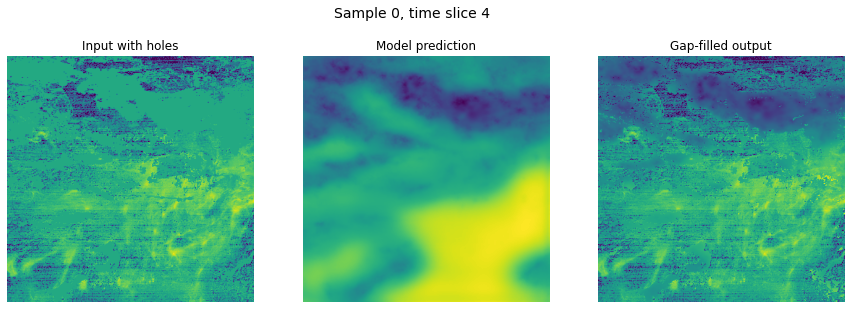

(tensor([[-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
         [-0.0000, -0.0000, -0.0000,  ..., -4.3429, -5.0000, -0.0000],
         [-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
         ...,
         [-0.6009,  0.1740, -1.0620,  ..., -1.6702,  0.5991,  0.3338],
         [-0.9646, -1.1254, -0.7146,  ..., -0.4401, -0.5985, -0.5369],
         [-1.1926, -0.8777, -0.5083,  ..., -0.2559, -0.3530,  0.0312]]),
 tensor([[-1.0897, -1.0759, -1.0483,  ..., -0.7729, -0.7577, -0.7501],
         [-1.0174, -1.0338, -1.0668,  ..., -0.7214, -0.6802, -0.6595],
         [-0.8727, -0.9497, -1.1038,  ..., -0.6186, -0.5251, -0.4783],
         ...,
         [ 1.3701,  1.3539,  1.3215,  ...,  1.5969,  1.6404,  1.6622],
         [ 1.4474,  1.4259,  1.3828,  ...,  1.6192,  1.6919,  1.7282],
         [ 1.4861,  1.4619,  1.4135,  ...,  1.6304,  1.7176,  1.7612]]),
 tensor([[-1.0897, -1.0759, -1.0483,  ..., -0.7729, -0.7577, -0.7501],
         [-1.0174, -1.0338, -1.0668,  ..., -4

In [38]:
import torch
import matplotlib.pyplot as plt

def run_inference_and_plot(model, dataset, idx, device="cuda"):
    """
    Run inference on a single dataset sample and show frame-by-frame overlays
    for the central time slice (t = T//2).

    Args:
        model: trained PConvUNet3D (or similar)
        dataset: dataset object with __getitem__
        idx: index of sample to visualize
        device: torch device ("cuda" or "cpu")
    """
    model.eval()
    sample = dataset[idx]

    # Fetch tensors and move to device
    x = sample["masked_img"].unsqueeze(0).to(device)       # [1,1,T,H,W]
    m = sample["known_and_fake_mask"].unsqueeze(0).to(device)  # [1,1,T,H,W]
    y_true = sample["target"].unsqueeze(0).to(device)      # [1,1,T,H,W] (or [1,1,H,W])

    with torch.no_grad():
        pred, _ = model(x, m)  # [1,1,T,H,W]

    # Gap-filled: prediction in holes + original where known
    filled = pred * (1 - m) + x * m

    # Central time slice
    t0 = x.shape[2] // 2

    inp = x[0,0,t0].detach().cpu()
    pred = pred[0,0,t0].detach().cpu()
    fill = filled[0,0,t0].detach().cpu()

    # Plot
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1); plt.title("Input with holes")
    plt.imshow(inp, cmap="viridis"); plt.axis("off")

    plt.subplot(1,3,2); plt.title("Model prediction")
    plt.imshow(pred, cmap="viridis"); plt.axis("off")

    plt.subplot(1,3,3); plt.title("Gap-filled output")
    plt.imshow(fill, cmap="viridis"); plt.axis("off")

    plt.suptitle(f"Sample {idx}, time slice {t0}", fontsize=14)
    plt.show()

    return inp, pred, fill
run_inference_and_plot(m, train_ds, 0, device="cuda")